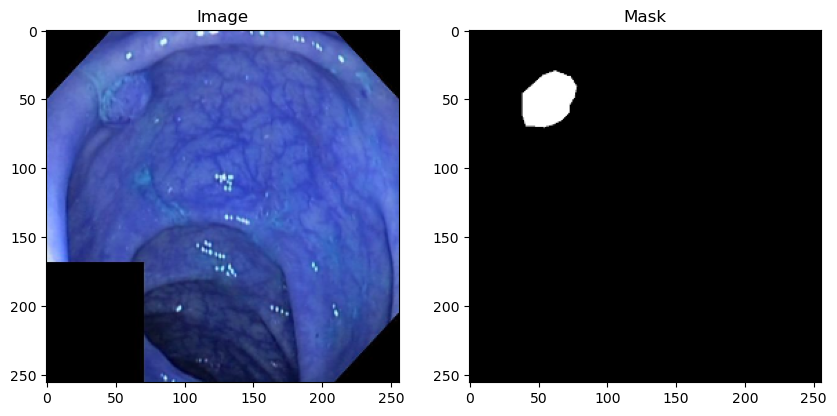

In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Paths to your dataset
image_path = "images"
mask_path = "masks"

# Load and preprocess data
def load_data(image_path, mask_path, image_size=(256, 256)):
    images, masks = [], []
    for file_name in os.listdir(image_path):
        # Load image and mask
        img = cv2.imread(os.path.join(image_path, file_name))
        mask = cv2.imread(os.path.join(mask_path, file_name), 0)  # Load as grayscale
        
        # Resize and normalize
        img = cv2.resize(img, image_size) / 255.0
        mask = cv2.resize(mask, image_size) / 255.0
        
        images.append(img)
        masks.append(mask)
    
    images = np.array(images, dtype=np.float32)
    masks = np.expand_dims(np.array(masks, dtype=np.float32), axis=-1)  # Add channel dimension
    return images, masks

# Load and split dataset
images, masks = load_data(image_path, mask_path)
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

# Display sample
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(X_train[0])
plt.title("Image")
plt.subplot(1, 2, 2)
plt.imshow(y_train[0].squeeze(), cmap="gray")
plt.title("Mask")
plt.show()


In [2]:
from tensorflow.keras import layers, Model, Input

def conv_block(x, filters):
    x = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    return x

def build_unet_plus_plus(input_shape=(256, 256, 3)):
    inputs = Input(input_shape)
    
    # Encoder
    conv1 = conv_block(inputs, 64)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)
    
    conv2 = conv_block(pool1, 128)
    pool2 = layers.MaxPooling2D((2, 2))(conv2)

    conv3 = conv_block(pool2, 256)
    pool3 = layers.MaxPooling2D((2, 2))(conv3)

    conv4 = conv_block(pool3, 512)
    pool4 = layers.MaxPooling2D((2, 2))(conv4)

    # Bottleneck
    bottleneck = conv_block(pool4, 1024)
    
    # Decoder (with skip connections)
    up4 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bottleneck)
    merge4 = layers.concatenate([conv4, up4])  # Skip connection
    conv4_1 = conv_block(merge4, 512)

    up3 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv4_1)
    merge3 = layers.concatenate([conv3, up3])  # Skip connection
    conv3_1 = conv_block(merge3, 256)

    up2 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv3_1)
    merge2 = layers.concatenate([conv2, up2])  # Skip connection
    conv2_1 = conv_block(merge2, 128)

    up1 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv2_1)
    merge1 = layers.concatenate([conv1, up1])  # Skip connection
    conv1_1 = conv_block(merge1, 64)

    # Output layer
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(conv1_1)

    model = Model(inputs, outputs)
    return model

# Build the model
unet_pp_model = build_unet_plus_plus()

# Compile the model
unet_pp_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model Summary
unet_pp_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 256, 256, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 256, 256, 64)      │           1,792 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 256, 256, 64)      │          36,928 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 128, 128, 64)      │               0 │ conv2d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 128, 128, 128)     │          73,856 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 128, 128, 128)     │         147,584 │ conv2d_2[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 64, 64, 128)       │               0 │ conv2d_3[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 64, 64, 256)       │         295,168 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_5 (Conv2D)             │ (None, 64, 64, 256)       │         590,080 │ conv2d_4[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_2               │ (None, 32, 32, 256)       │               0 │ conv2d_5[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_6 (Conv2D)             │ (None, 32, 32, 512)       │       1,180,160 │ max_pooling2d_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_7 (Conv2D)             │ (None, 32, 32, 512)       │       2,359,808 │ conv2d_6[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_3               │ (None, 16, 16, 512)       │               0 │ conv2d_7[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_8 (Conv2D)             │ (None, 16, 16, 1024)      │       4,719,616 │ max_pooling2d_3[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_9 (Conv2D)             │ (None, 16, 16, 1024)      │       9,438,208 │ conv2d_8[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_transpose              │ (None, 32, 32, 512)       │       2,097,66

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [3]:
history = unet_pp_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=16,
    epochs=10
)


Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 253s 5s/step - accuracy: 0.8278 - loss: 0.6011 - val_accuracy: 0.8336 - val_loss: 0.3934
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 255s 5s/step - accuracy: 0.8388 - loss: 0.3829 - val_accuracy: 0.8336 - val_loss: 0.3950
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 254s 5s/step - accuracy: 0.8353 - loss: 0.3865 - val_accuracy: 0.8336 - val_loss: 0.3883
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 257s 5s/step - accuracy: 0.8366 - loss: 0.3773 - val_accuracy: 0.8336 - val_loss: 0.3824
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 256s 5s/step - accuracy: 0.8334 - loss: 0.3712 - val_accuracy: 0.8336 - val_loss: 0.3757
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 374s 8s/step - accuracy: 0.8396 - loss: 0.3595 - val_accuracy: 0.8336 - val_loss: 0.3749
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 316s 6s/step - accuracy: 0.8498 - loss: 0.3452 - val_accuracy: 0.8336 - val_loss: 0.3871
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 263s 5s/step - accuracy: 0.8382 - loss: 0.3763 - val_accuracy: 0.8307 - v

KeyboardInterrupt: 

In [ ]:
# Predict on a validation image
predicted_mask = unet_pp_model.predict(X_val[:1])[0]

# Plot original image, ground truth mask, and predicted mask
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(X_val[0])
plt.title("Original Image")
plt.subplot(1, 3, 2)
plt.imshow(y_val[0].squeeze(), cmap="gray")
plt.title("Ground Truth Mask")
plt.subplot(1, 3, 3)
plt.imshow(predicted_mask.squeeze(), cmap="gray")
plt.title("Predicted Mask")
plt.show()
